In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, Comment
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score
from itertools import product
from sklearn.preprocessing import label_binarize

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    'subject_len': mail_dict['subject_len'],
                    'body_len': mail_dict['body_len'],
                    'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    'return_path_match_from': mail_dict['return_path_match_from'],
                    'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    'Content-type': mail_dict['Content-type'],
                    'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    'has_defects': mail_dict['has_defects'],
                    'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
...
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- How 4,500 Worksites Are Getting Healthier Right Now.eml


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 34 columns):
Content-type              772 non-null object
DKIM                      784 non-null object
DMARC                     784 non-null object
DOTW                      784 non-null object
HOTD                      784 non-null object
SPF                       784 non-null object
TAP-Score                 784 non-null object
body_len                  784 non-null float64
from_tld                  784 non-null object
has_attachments           784 non-null float64
has_defects               784 non-null float64
has_email                 784 non-null float64
has_html_content          784 non-null float64
has_inline_img            784 non-null float64
has_javascript            784 non-null float64
has_masq_link             784 non-null float64
has_repeat_link           784 non-null float64
has_unsubscribe_link      784 non-null float64
has_url                   784 non-null float64
is_multipa

In [11]:
df.head()

,Content-type,DKIM,DMARC,DOTW,HOTD,SPF,TAP-Score,body_len,from_tld,has_attachments,...,num_masq_link,num_uniq_email,num_uniq_link,num_uniq_url,num_url,num_url_repeats,return_path_match_from,subject_len,target,text
0,Multipart/mixed,PASS,absent,3,10,NONE,1,441.0,org,1.0,...,0.0,1.0,0.0,7.0,8.0,1.0,1.0,17.0,investigate,Goodchem Document Review attached document and...
1,Multipart/alternative,PASS,absent,2,11,NONE,0,171.0,it,0.0,...,0.0,0.0,1.0,2.0,2.0,0.0,1.0,32.0,investigate,Validate your Office 365 account You hav...
2,Multipart/alternative,PASS,absent,1,13,PASS,1,211.0,net.pl,0.0,...,1.0,0.0,1.0,1.0,2.0,1.0,1.0,31.0,investigate,INVOICE YAX-80-97157 Tom Jensen http://challen...
3,text/plain,NONE,absent,2,11,NEUTRAL,1,254.0,com,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,15.0,investigate,"Invoice Problem Hello Jessica Rael, Wasn’t ..."
4,text/plain,NONE,absent,3,11,PASS,1,192.0,co.jp,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,24.0,investigate,Invoice from Karen Laman Please see attached i...


Create a function to clean the text

In [12]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text

In [13]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 8.724s


In [14]:
df['cleaned_text'] = pd.Series(corpus).values

Convert cells that are not recognized as a number or just to get rid of float

In [15]:
#https://stackoverflow.com/a/28910914
for col in [
    'body_len',
    'has_attachments',
    'has_defects',
    'has_email',
    'has_html_content',
    'has_inline_img',
    'has_javascript',
    'has_masq_link',
    'has_repeat_link',
    'has_unsubscribe_link',
    'has_url',
    'is_multipart',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_link',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'return_path_match_from',
    'subject_len',
    #'TAP-Score',
]:
    df[col] = df[col].astype(int)  

Change categorical columns into one-hot encoding

In [16]:
categorical_cols = [
    'DKIM',
    'DMARC',
    'SPF',
    'from_tld',
    'Content-type',
    'DOTW',
    'HOTD',
    'TAP-Score',
]
df_categorical = pd.get_dummies(df[categorical_cols])
df.drop(categorical_cols, axis=1, inplace=True)
df = pd.concat([df,df_categorical], axis=1)
df.head()

,body_len,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,...,HOTD_19,HOTD_20,HOTD_21,HOTD_22,HOTD_23,TAP-Score_-1,TAP-Score_0,TAP-Score_1,TAP-Score_2,TAP-Score_3
0,441,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,171,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,211,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,254,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,192,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Split the sample set into test and training sets

In [17]:
df_target = df['target']
df_feats = df.drop(['target','text'],axis=1)
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [18]:
train_feats.head()

,body_len,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,...,HOTD_19,HOTD_20,HOTD_21,HOTD_22,HOTD_23,TAP-Score_-1,TAP-Score_0,TAP-Score_1,TAP-Score_2,TAP-Score_3
659,9878,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
223,327,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
41,2266,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,157,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
661,1994,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [19]:
train_labels.value_counts()

ignore         318
investigate    309
Name: target, dtype: int64

In [20]:
train_feats.shape

(627, 141)

In [21]:
test_labels.value_counts()

ignore         82
investigate    75
Name: target, dtype: int64

#### TFIDF Creation

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=True
)
train_feats_text = vectorizer.fit_transform(train_feats['cleaned_text'].values.tolist())
test_feats_text = vectorizer.transform(test_feats['cleaned_text'].values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.496s


In [23]:
train_feats_text.shape

(627, 9338)

In [24]:
test_feats_text.shape

(157, 9338)

#### LSA

In [25]:
svd = TruncatedSVD(n_components=100)
train_feats_text = svd.fit_transform(train_feats_text)
train_feats_text.shape

(627, 100)

In [26]:
test_feats_text = svd.transform(test_feats_text)
test_feats_text.shape

(157, 100)

Change the sparse matrix back into a data frame

In [27]:
#https://stackoverflow.com/a/50624143
train_feats_text_df = pd.DataFrame(train_feats_text)

In [28]:
train_feats_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 100 columns):
0     627 non-null float64
1     627 non-null float64
2     627 non-null float64
3     627 non-null float64
4     627 non-null float64
5     627 non-null float64
6     627 non-null float64
7     627 non-null float64
8     627 non-null float64
9     627 non-null float64
10    627 non-null float64
11    627 non-null float64
12    627 non-null float64
13    627 non-null float64
14    627 non-null float64
15    627 non-null float64
16    627 non-null float64
17    627 non-null float64
18    627 non-null float64
19    627 non-null float64
20    627 non-null float64
21    627 non-null float64
22    627 non-null float64
23    627 non-null float64
24    627 non-null float64
25    627 non-null float64
26    627 non-null float64
27    627 non-null float64
28    627 non-null float64
29    627 non-null float64
30    627 non-null float64
31    627 non-null float64
32    627 non-null float64
33 

Add prefix to the column names

In [29]:
#https://stackoverflow.com/a/35088280
train_feats_text_df = train_feats_text_df.add_prefix('LSA_')

In [30]:
train_feats_text_df.head()

,LSA_0,LSA_1,LSA_2,LSA_3,LSA_4,LSA_5,LSA_6,LSA_7,LSA_8,LSA_9,...,LSA_90,LSA_91,LSA_92,LSA_93,LSA_94,LSA_95,LSA_96,LSA_97,LSA_98,LSA_99
0,0.198452,-0.100124,0.052720,-0.016505,-0.018664,0.020708,-0.035197,-0.145678,0.037281,-0.021787,...,0.016755,-0.002859,0.055418,-0.022425,0.020627,-0.079463,-0.106796,0.032270,0.071236,-0.078473
1,0.189826,0.125449,-0.164279,-0.085729,-0.006505,-0.032514,-0.020991,0.063830,-0.063989,-0.039059,...,-0.062189,0.003825,-0.016548,-0.018468,0.100015,0.037837,-0.046037,-0.014904,0.067403,-0.066438
2,0.208488,0.053980,0.135231,0.010817,0.130130,0.251791,-0.072103,-0.001816,0.017195,-0.027785,...,0.011088,-0.047460,-0.013404,0.010568,0.094560,0.037557,0.067877,0.000901,-0.068970,-0.041341
3,0.018045,0.019488,-0.018114,-0.007606,0.020610,-0.006993,0.006831,0.015792,0.024343,-0.010621,...,-0.030560,-0.046423,-0.079578,0.116727,0.029546,-0.008787,-0.023057,-0.092396,0.063782,-0.004029
4,0.153204,-0.065094,0.025279,-0.010985,-0.014063,-0.061849,0.021082,0.268398,-0.254423,-0.211880,...,-0.041864,-0.009894,0.054546,-0.002838,0.004058,-0.031357,-0.003382,-0.014308,0.001469,-0.023545


Combine back with non-text features dataframe

In [31]:
train_feats = pd.concat([
    train_feats.reset_index(drop=True),
    train_feats_text_df.reset_index(drop=True)
],axis=1)

In [32]:
train_feats.drop('cleaned_text',axis=1,inplace=True)

In [33]:
train_feats.shape

(627, 240)

In [34]:
test_feats_text_df = pd.DataFrame(test_feats_text)
test_feats_text_df = test_feats_text_df.add_prefix('LSA_')
test_feats = pd.concat([
    test_feats.reset_index(drop=True),
    test_feats_text_df.reset_index(drop=True)
],axis=1)
test_feats.drop('cleaned_text',axis=1,inplace=True)
test_feats.shape

(157, 240)

Function to keep track of scoring and for printing results out

In [35]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'recall' not in score_dict:
        score_dict['recall'] = []    
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    recall = recall_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['recall'].append((clf_name,recall))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('Recall score: %0f' % recall)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [36]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.166s
LinearSVC Scores:

Accuracy of data already seen: 0.8549
Accuracy of data not seen: 0.8599
F1 score: 0.8608
Recall score: 0.906667
False Negatives: 7


In [37]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 0.118s
SVC Scores:

Accuracy of data already seen: 0.9506
Accuracy of data not seen: 0.9236
F1 score: 0.9178
Recall score: 0.893333
False Negatives: 8


#### Extra Trees Classifier

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 0.170s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9427
F1 score: 0.9404
Recall score: 0.946667
False Negatives: 4


Get Feature Importances

In [39]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = train_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. return_path_match_from (0.060203)
2. has_unsubscribe_link (0.057886)
3. LSA_1 (0.047646)
4. LSA_3 (0.035637)
5. Content-type_Multipart/alternative (0.032040)
6. SPF_PASS (0.029711)
7. LSA_2 (0.028767)
8. body_len (0.026819)
9. has_html_content (0.026609)
10. num_uniq_url (0.020496)
11. from_tld_com (0.018512)
12. is_multipart (0.017326)
13. num_url (0.017029)
14. Content-type_text/plain (0.015524)
15. num_link (0.014389)
16. num_uniq_link (0.013836)
17. SPF_NONE (0.012473)
18. LSA_7 (0.011429)
19. has_attachments (0.010185)
20. DKIM_PASS (0.009995)
21. LSA_4 (0.009792)
22. LSA_0 (0.009220)
23. DKIM_NONE (0.008789)
24. subject_len (0.008380)
25. LSA_5 (0.008352)


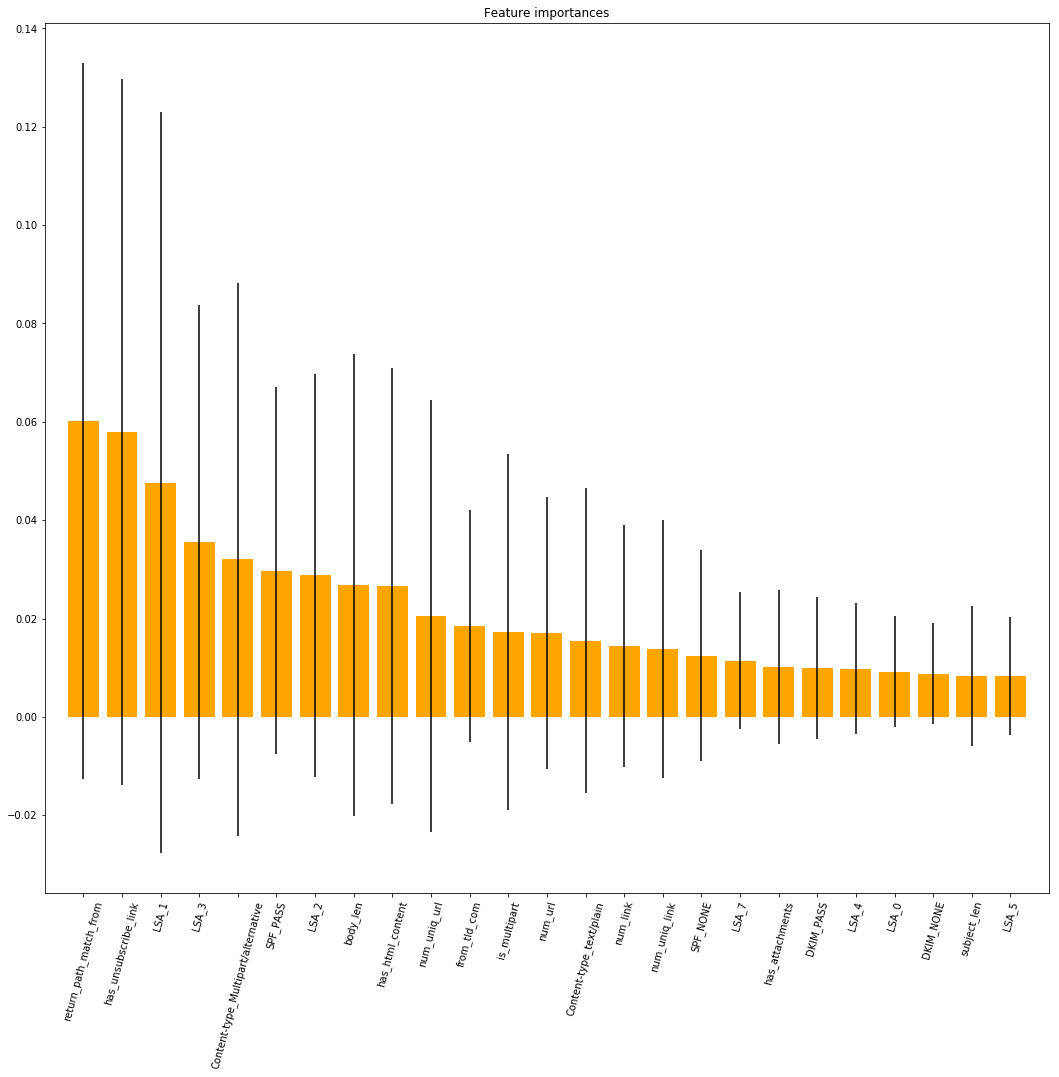

In [40]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 0.672s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9682
F1 score: 0.9669
Recall score: 0.973333
False Negatives: 2


#### XGBoost

In [42]:
from xgboost import XGBClassifier
t0 = time()
xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
xgb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

done in 0.874s
XGBClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9490
F1 score: 0.9467
Recall score: 0.946667
False Negatives: 4


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Neural Net

In [43]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 0.049s
MLPClassifier Scores:

Accuracy of data already seen: 0.5199
Accuracy of data not seen: 0.5414
F1 score: 0.0769
Recall score: 0.040000
False Negatives: 72


#### Naive Bayes

In [44]:
# from sklearn.naive_bayes import MultinomialNB
# t0 = time()
# nb_clf = MultinomialNB(alpha=.001)
# nb_clf.fit(train_feats.drop('TAP-Score',axis=1), train_labels)
# print("done in %0.3fs" % (time() - t0))
# score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

In [45]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.005s
GaussianNB Scores:

Accuracy of data already seen: 0.8293
Accuracy of data not seen: 0.8599
F1 score: 0.8472
Recall score: 0.813333
False Negatives: 14


#### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.295s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9427
F1 score: 0.9412
Recall score: 0.960000
False Negatives: 3


In [47]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = train_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. LSA_1 (0.113399)
2. LSA_2 (0.087258)
3. body_len (0.080105)
4. num_url (0.055756)
5. LSA_3 (0.042814)
6. num_uniq_link (0.041332)
7. num_link (0.040021)
8. num_uniq_url (0.034994)
9. return_path_match_from (0.023672)
10. LSA_7 (0.017050)
11. has_unsubscribe_link (0.015711)
12. subject_len (0.014386)
13. has_html_content (0.013644)
14. Content-type_Multipart/alternative (0.012386)
15. LSA_0 (0.012158)
16. SPF_PASS (0.010287)
17. LSA_4 (0.008712)
18. Content-type_text/plain (0.008207)
19. LSA_21 (0.007735)
20. LSA_5 (0.007208)
21. num_url_repeats (0.007118)
22. LSA_14 (0.006683)
23. LSA_29 (0.006299)
24. LSA_6 (0.006240)
25. LSA_33 (0.005690)


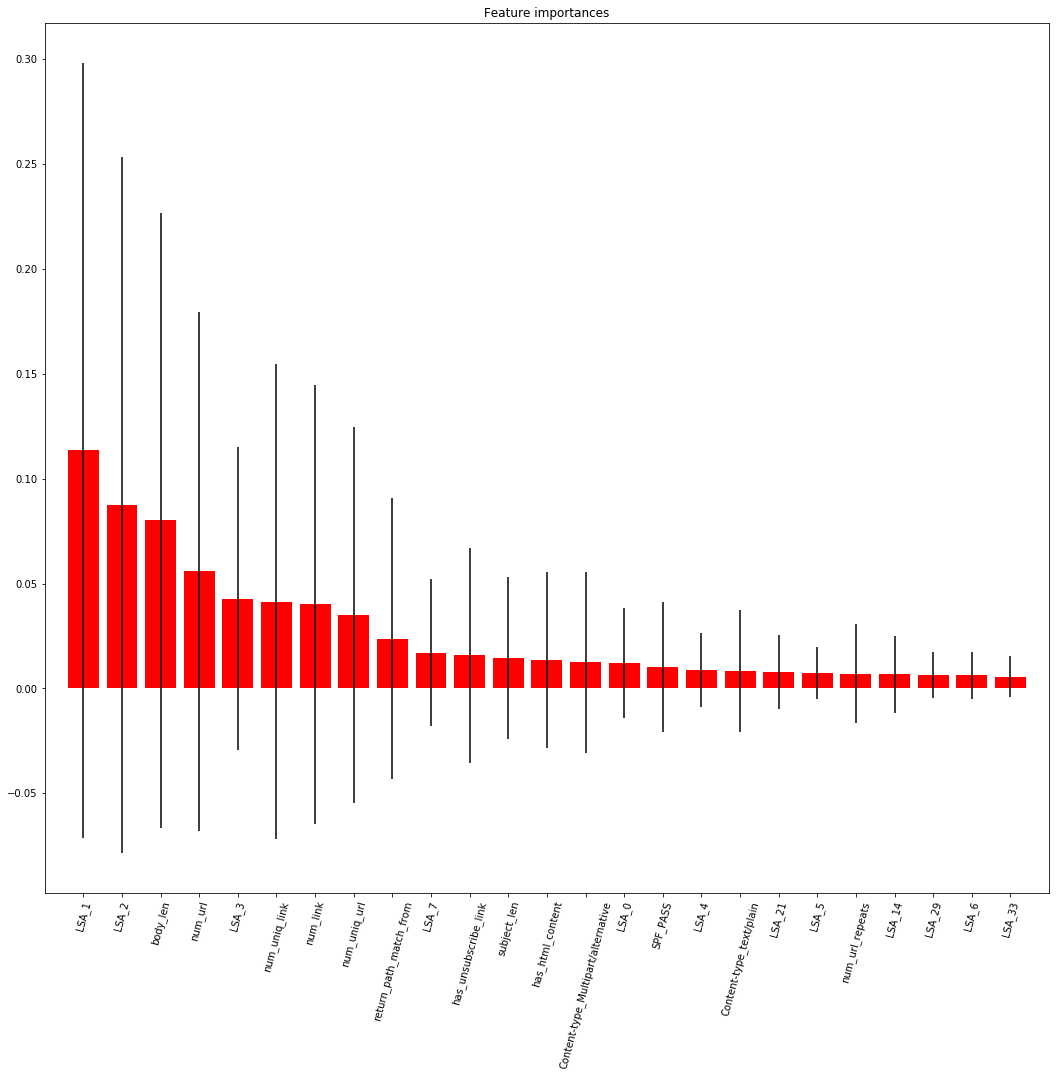

In [48]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [49]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.006s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.8900
Accuracy of data not seen: 0.9299
F1 score: 0.9290
Recall score: 0.960000
False Negatives: 3


#### NearestCentroid

In [50]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.005s
NearestCentroid Scores:

Accuracy of data already seen: 0.7097
Accuracy of data not seen: 0.7325
F1 score: 0.7813
Recall score: 1.000000
False Negatives: 0


#### AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 0.818s
AdaBoostClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9554
F1 score: 0.9536
Recall score: 0.960000
False Negatives: 3


#### QuadraticDiscriminantAnalysis

In [52]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

done in 0.031s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 0.8820
Accuracy of data not seen: 0.7771
F1 score: 0.7009
Recall score: 0.546667
False Negatives: 34


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### GaussianProcessClassifier

In [53]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 0.252s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8280
F1 score: 0.8235
Recall score: 0.840000
False Negatives: 12


#### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.053s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9299
F1 score: 0.9252
Recall score: 0.906667
False Negatives: 7


#### LogisticRegression

In [55]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.033s
LogisticRegression Scores:

Accuracy of data already seen: 0.8900
Accuracy of data not seen: 0.9108
F1 score: 0.9079
Recall score: 0.920000
False Negatives: 6


#### PassiveAggressiveClassifier

In [56]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.011s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.5183
Accuracy of data not seen: 0.5287
F1 score: 0.0263
Recall score: 0.013333
False Negatives: 74


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [57]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.021s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9697
Accuracy of data not seen: 0.9299
F1 score: 0.9272
Recall score: 0.933333
False Negatives: 5


#### SGDClassifier

In [58]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.010s
SGDClassifier Scores:

Accuracy of data already seen: 0.5152
Accuracy of data not seen: 0.5287
F1 score: 0.0263
Recall score: 0.013333
False Negatives: 74


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [59]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.372s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 0.8501
Accuracy of data not seen: 0.9045
F1 score: 0.9068
Recall score: 0.973333
False Negatives: 2


#### BaggingClassifier

In [60]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 1.257s
BaggingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9490
F1 score: 0.9474
Recall score: 0.960000
False Negatives: 3


#### VotingClassifier

In [61]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
#    ('nn',nn_clf),
    ('bg',bg_clf),
#     ('et',et_clf),
    ('xgb',xgb_clf),
#      ('svm',svm_clf),
#     ('lr',lr_clf),
#      ('nc',nc_clf),
#      ('knn',knn_clf),
#      ('cc',cc_clf),
#     ('rd',rd_clf),
     ('rf',rf_clf),
#     ('pa',pa_clf),
#     ('gb',gb_clf),
])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 2.424s


In [62]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
recall = recall_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('Recall score: %0.4f' % recall)
print('False Negatives: %0d' % FN)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

VotingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9554
F1 score: 0.9536
Recall score: 0.9600
False Negatives: 3


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [63]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest Recall Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['recall'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)    
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

GradientBoostingClassifier: 0.9682
AdaBoostClassifier: 0.9554
XGBClassifier: 0.9490


Best F1 Score:

GradientBoostingClassifier: 0.9669
AdaBoostClassifier: 0.9536
BaggingClassifier: 0.9474


Best Recall Score:

NearestCentroid: 1.0000
GradientBoostingClassifier: 0.9733
CalibratedClassifierCV: 0.9733


Best False Negative Classifier:

NearestCentroid: 0
GradientBoostingClassifier: 2
CalibratedClassifierCV: 2


#### Confusion Matrix of Top Algos

In [64]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [66]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

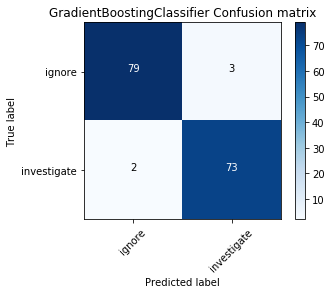

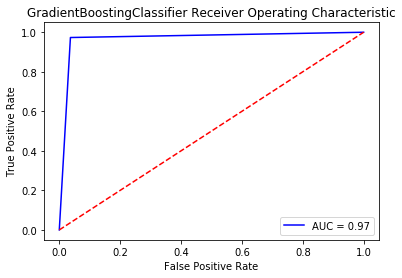

In [70]:
display_conf_mat(gb_clf,test_feats,test_labels)
plot_roc_curve(gb_clf,test_feats,test_labels)

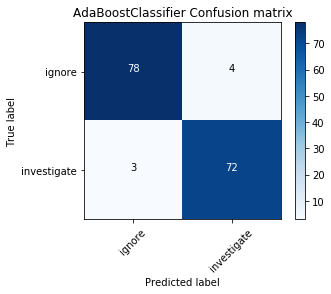

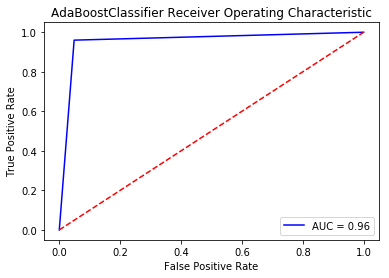

In [71]:
display_conf_mat(ab_clf,test_feats,test_labels)
plot_roc_curve(ab_clf,test_feats,test_labels)

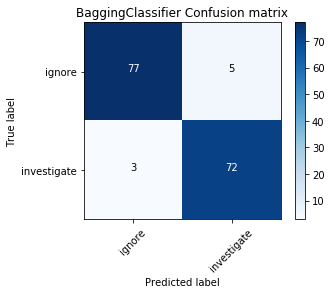

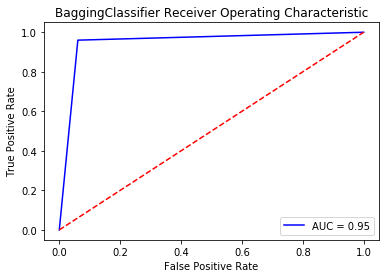

In [68]:
display_conf_mat(bg_clf,test_feats,test_labels)
plot_roc_curve(bg_clf,test_feats,test_labels)